# Notebook to Calculate the Inter-Annotator Agreement

### Import the libraries

In [1]:
import sys
import pandas as pd
import collections 
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import scipy.stats
import random
from itertools import chain
from itertools import combinations
sys.path.insert(0, '..')
from src.experiment_utils.helper_classes import token, span, repository
from src.d02_corpus_statistics.corpus import Corpus
from src.d03_inter_annotator_agreement.inter_annotator_agremment import Inter_Annotator_Agreement
from definitions import df_annotation_marker
from src.d03_inter_annotator_agreement.inter_annotator_agremment import row_to_span_list, keep_valid_anotations
from src.d03_inter_annotator_agreement.scoring_functions import create_scoring_matrix

from definitions import ROOT_DIR


Set seed for Py-Gamma

In [2]:
random.seed(101)

## Introduction

Most of the functions used in this tutorial are based on the "Corpus" class. Please follow the Turorial before.

In [3]:
dataframe_dir = os.path.join(ROOT_DIR,'data/02_processed_to_dataframe', 'preprocessed_dataframe.pkl')
stat_df = pd.read_pickle(dataframe_dir)
stat_df.head()

,Policy,Text,Tokens,Article_State,Finished_Annotators,Curation,A,C,F,B,E,G,D
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_43,,article 43\r\nexercise of the delegation\r\n1....,"[token id: T1, start:0 stop:7 text:article tag...",CURATION_FINISHED,"[A, C]",[span id:CUR0 annotator:Curation layer:Instrum...,[span id:A1 annotator:A layer:Instrumenttypes ...,[span id:C1 annotator:C layer:Policydesignchar...,,,,,
EU_32019R0631_Title_0_Chapter_0_Section_0_Article_12,,article 12\r\nreal-world co2 emissions and fue...,"[token id: T459, start:0 stop:7 text:article t...",CURATION_FINISHED,"[F, B]",[span id:CUR36 annotator:Curation layer:Instru...,,,[span id:F1 annotator:F layer:Instrumenttypes ...,[span id:B1 annotator:B layer:Policydesignchar...,,,
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_11,,article 11\r\njoint projects between member st...,"[token id: T974, start:0 stop:7 text:article t...",CURATION_FINISHED,"[C, F]",[span id:CUR116 annotator:Curation layer:Instr...,,[span id:C28 annotator:C layer:Instrumenttypes...,[span id:F58 annotator:F layer:Instrumenttypes...,,,,
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_56,,article 56\r\namendments to directive (eu) 201...,"[token id: T2008, start:0 stop:7 text:article ...",CURATION_FINISHED,"[A, C]",[span id:CUR202 annotator:Curation layer:Polic...,[span id:A38 annotator:A layer:Policydesigncha...,[span id:C129 annotator:C layer:Policydesignch...,,,,,
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_03,,article 3\r\nbinding overall union target for ...,"[token id: T2220, start:0 stop:7 text:article ...",CURATION_FINISHED,"[C, F, B]",[span id:CUR211 annotator:Curation layer:Instr...,,[span id:C138 annotator:C layer:Instrumenttype...,[span id:F165 annotator:F layer:Instrumenttype...,[span id:B27 annotator:B layer:Instrumenttypes...,,,


First create a object of class Inter_Annotator_Agreement. The constructor takes a stat_df as input, has a optional argument DEBUG where only the first 10 articles are taken to test different functions. Per default, the preamble ("Front" and "Whereas" articles) is excluded.



In [4]:
test_evaluator = Inter_Annotator_Agreement(stat_df, front_and_whereas = False)
test_evaluator_debug = Inter_Annotator_Agreement(stat_df, DEBUG = True)

In [5]:
test_evaluator.df.shape

(412, 13)

In [6]:
test_evaluator_debug.df.shape

(10, 13)

Inter_Annotator_Agreement is a child class of the Corpus class, so all methods of the Corpus class are available:

In [7]:
test_dir = repository(policy = 'EU_32008R1099')
test_evaluator.get_span_list(conditional_rep = test_dir, annotators = 'annotators', item = 'tag', value =  'Tech_LowCarbon')

[span id:F3882 annotator:F layer:Technologyandapplicationspecificity feature:TechnologySpecificity tag:Tech_LowCarbon start:18 stop:25 text:nuclear,
 span id:F3883 annotator:F layer:Technologyandapplicationspecificity feature:TechnologySpecificity tag:Tech_LowCarbon start:95 stop:109 text:nuclear energy,
 span id:F3884 annotator:F layer:Technologyandapplicationspecificity feature:TechnologySpecificity tag:Tech_LowCarbon start:151 stop:158 text:nuclear,
 span id:F5161 annotator:F layer:Technologyandapplicationspecificity feature:TechnologySpecificity tag:Tech_LowCarbon start:125 stop:141 text:renewable energy,
 span id:F5162 annotator:F layer:Technologyandapplicationspecificity feature:TechnologySpecificity tag:Tech_LowCarbon start:393 stop:409 text:renewable energy,
 span id:F5163 annotator:F layer:Technologyandapplicationspecificity feature:TechnologySpecificity tag:Tech_LowCarbon start:499 stop:515 text:renewable energy,
 span id:F5164 annotator:F layer:Technologyandapplicationspecif

To calculate the inter-annonator agreement, there are two options: 1) appending the score to dataframe and 2) getting the total score based on a spanlist. We will now walk through both of these options.


## Append the score to dataframe

This method appends the inter-annotator agreement for each article based on a set of inter-annotator agreement measures. As the scores can be calculated in parallel, this is the recommended method for computationally intensive scores.

First, we only consider the articles where the curation is finished and the text was annotated by at least two annotators:

In [8]:
test_evaluator.keep_only_finished_articles()

Define a list of scoring metrics:

In [9]:
scoring_metrics = ['f1_exact', 'f1_tokenwise', 'f1_heuristic']

We will now make use of the function
**append_total_score_per_article(scoring_metrics, parallel = False, ** optional_tuple_properties)**.

This function calculates the individual score for each article and for each metric defined in scoring_metrics (can be a list of metrics or a single metric). For each metric, a new column is appended to the dataframe, therefore the scores can be stored and don't have to be recalculated. To speed up the computation, the scores can be calculated in parallel using the pandarell library. The kwargs "optional_tuple_properties" are reserved for pygamma properties such as a dissimilarity matrix. 



In [10]:
test_evaluator.append_total_score_per_article(scoring_metrics)

100%|██████████████████████████████████████████████| 412/412 [00:00<00:00, 744.46it/s]


In [11]:
test_evaluator.get_total_score_df(weight_by = 'no_weighting')

{'f1_exact_score': 0.40028724799007476,
 'f1_heuristic_score': 0.5275951402554365,
 'f1_tokenwise_score': 0.5197949109942909}

In [12]:
test_evaluator.df.head()

,Policy,Text,Tokens,Article_State,Finished_Annotators,Curation,A,C,F,B,E,G,D,f1_exact_score,f1_tokenwise_score,f1_heuristic_score
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_43,,article 43\r\nexercise of the delegation\r\n1....,"[token id: T1, start:0 stop:7 text:article tag...",CURATION_FINISHED,"[A, C]",[span id:CUR0 annotator:Curation layer:Instrum...,[span id:A1 annotator:A layer:Instrumenttypes ...,[span id:C1 annotator:C layer:Policydesignchar...,,,,,,0.218750,0.494915,0.281250
EU_32019R0631_Title_0_Chapter_0_Section_0_Article_12,,article 12\r\nreal-world co2 emissions and fue...,"[token id: T459, start:0 stop:7 text:article t...",CURATION_FINISHED,"[F, B]",[span id:CUR36 annotator:Curation layer:Instru...,,,[span id:F1 annotator:F layer:Instrumenttypes ...,[span id:B1 annotator:B layer:Policydesignchar...,,,,0.289157,0.385827,0.421687
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_11,,article 11\r\njoint projects between member st...,"[token id: T974, start:0 stop:7 text:article t...",CURATION_FINISHED,"[C, F]",[span id:CUR116 annotator:Curation layer:Instr...,,[span id:C28 annotator:C layer:Instrumenttypes...,[span id:F58 annotator:F layer:Instrumenttypes...,,,,,0.567308,0.559615,0.653846
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_56,,article 56\r\namendments to directive (eu) 201...,"[token id: T2008, start:0 stop:7 text:article ...",CURATION_FINISHED,"[A, C]",[span id:CUR202 annotator:Curation layer:Polic...,[span id:A38 annotator:A layer:Policydesigncha...,[span id:C129 annotator:C layer:Policydesignch...,,,,,,0.736842,0.875000,0.736842
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_03,,article 3\r\nbinding overall union target for ...,"[token id: T2220, start:0 stop:7 text:article ...",CURATION_FINISHED,"[C, F, B]",[span id:CUR211 annotator:Curation layer:Instr...,,[span id:C138 annotator:C layer:Instrumenttype...,[span id:F165 annotator:F layer:Instrumenttype...,[span id:B27 annotator:B layer:Instrumenttypes...,,,,0.420198,0.511835,0.544511


There is also a normal implementation which uses parallel

In [13]:
test_evaluator.append_total_score_per_article(scoring_metrics, parallel = True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Gamma-score

The gamma-score is a special case that is calculated using the pygamma-agreement package. To calculate the gamma-score, we have the option to feed in a dissimilarity matrix and a list of all the possible annotated spans. The dissimilarity matrix can be calculated via the create_scoring_matrix function. Each mismatch between tags of the same feature or layer is penalized less than a mismatch between different features or layers. For more details, refer to https://pygamma-agreement.readthedocs.io/en/latest/. 

This dissimilarity matrix can be fed into the function as kwargs. When soft_tagset_dissimilarity = False and soft_layer_dissimilarity = False, all the mismatches are penalized equally. Set soft_dissimilarity_penality = 0.5 and soft_tagset_dissimilarity = True for example for giving less weight to categorization error within the same feature.

In [14]:
# create custom scoring matrix
# by setting soft tagset dissimilarity equal true, mismatches in the same tagset are penalized less
# if soft layer dissimilarity would be set true, mismatches in the same layer would be penalized less

#category_list, cat_dissimilarity_matrix = create_scoring_matrix(os.path.join(ROOT_DIR,'data/Coding_Scheme.json'),  soft_dissimilarity_penality = 0.5, soft_tagset_dissimilarity = True, soft_layer_dissimilarity = False)

In [15]:
# To penalize all the missmatches equally, e.g no soft penalty. Comment out for soft penalty.
category_list, cat_dissimilarity_matrix = create_scoring_matrix(os.path.join(ROOT_DIR,'data/Coding_Scheme.json'), soft_tagset_dissimilarity = False, soft_layer_dissimilarity = False)

In [16]:
test_evaluator.append_total_score_per_article(scoring_metrics = 'pygamma', category_list = category_list, cat_dissimilarity_matrix = cat_dissimilarity_matrix, soft = False, parallel=True)



INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

+    75: >>>>>   4.968190993e+01 >=   4.968190993e+01   0.0% (1; 0)
+    75: mip =   4.968190993e+01 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

*   173: obj =   9.184259227e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   173: mip =     not found yet >=              -inf        (1; 0)
+   173: >>>>>   9.184259227e+01 >=   9.184259227e+01   0.0% (1; 0)
+   173: mip =   9.184259227e+01 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Size of triangular part is 254
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
254 rows, 248 columns, 738 non-zeros
      0: obj =   3.400000000e+01 inf =   1.270e+02 (127)
Long-step dual simplex will be used
Long-step dual simplex will be used
    106: obj =   1.321530305e+02 inf =   0.000e+00 (0)
Long-step dual simplex will be used
Long-step dual simplex will be used
*   265: obj =   1.236395443e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   265: mip =     not found yet >=              -inf        (1; 0)
Long-step dual simplex will be used
+   265: >>>>>   1.236395443e+02 >=   1.236395443e+02   0.0% (1; 0)
+   265: mip =   1.236395443e+02 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.6

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
77 rows, 45 columns, 104 non-zeros
45 integer variables, all of which are binary
Preprocessing...
1 hidden covering inequaliti(es) were detect

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
619 rows, 531 columns, 1506 non-zeros
531 integer variables, all of which are binary
Preprocessing...
112 hidden covering inequaliti(es) were detected
494 rows, 469 columns, 1382 non-zeros
469 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of tria

Checking out the dataframe now that shows the inter-annotator agreement scores for each article:

In [17]:
test_evaluator.df.head()

,Policy,Text,Tokens,Article_State,Finished_Annotators,Curation,A,C,F,B,E,G,D,f1_exact_score,f1_tokenwise_score,f1_heuristic_score,pygamma_score
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_43,,article 43\r\nexercise of the delegation\r\n1....,"[token id: T1, start:0 stop:7 text:article tag...",CURATION_FINISHED,"[A, C]",[span id:CUR0 annotator:Curation layer:Instrum...,[span id:A1 annotator:A layer:Instrumenttypes ...,[span id:C1 annotator:C layer:Policydesignchar...,,,,,,0.218750,0.494915,0.281250,0.414483
EU_32019R0631_Title_0_Chapter_0_Section_0_Article_12,,article 12\r\nreal-world co2 emissions and fue...,"[token id: T459, start:0 stop:7 text:article t...",CURATION_FINISHED,"[F, B]",[span id:CUR36 annotator:Curation layer:Instru...,,,[span id:F1 annotator:F layer:Instrumenttypes ...,[span id:B1 annotator:B layer:Policydesignchar...,,,,0.289157,0.385827,0.421687,0.429530
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_11,,article 11\r\njoint projects between member st...,"[token id: T974, start:0 stop:7 text:article t...",CURATION_FINISHED,"[C, F]",[span id:CUR116 annotator:Curation layer:Instr...,,[span id:C28 annotator:C layer:Instrumenttypes...,[span id:F58 annotator:F layer:Instrumenttypes...,,,,,0.567308,0.559615,0.653846,0.649654
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_56,,article 56\r\namendments to directive (eu) 201...,"[token id: T2008, start:0 stop:7 text:article ...",CURATION_FINISHED,"[A, C]",[span id:CUR202 annotator:Curation layer:Polic...,[span id:A38 annotator:A layer:Policydesigncha...,[span id:C129 annotator:C layer:Policydesignch...,,,,,,0.736842,0.875000,0.736842,0.708669
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_03,,article 3\r\nbinding overall union target for ...,"[token id: T2220, start:0 stop:7 text:article ...",CURATION_FINISHED,"[C, F, B]",[span id:CUR211 annotator:Curation layer:Instr...,,[span id:C138 annotator:C layer:Instrumenttype...,[span id:F165 annotator:F layer:Instrumenttype...,[span id:B27 annotator:B layer:Instrumenttypes...,,,,0.420198,0.511835,0.544511,0.573752


### Get total score

In [18]:
test_evaluator.df['Tokens'][1][27].get_token_spans()

[span id:CUR75 annotator:Curation layer:Technologyandapplicationspecificity feature:ApplicationSpecificity tag:App_Other start:173 stop:199 text:fuel or energy consumption,
 span id:CUR76 annotator:Curation layer:Technologyandapplicationspecificity feature:EnergySpecificity tag:Energy_Other start:173 stop:177 text:fuel]

The function **test_evaluator.get_total_score_df(scoring_metrics = 'all', annotator = 'all', weight_by = 'Tokens')** calculates the total scores specified in scoring metrics of the dataframe, either for a specific annotator or for all the annotators. The scores can be weighted by {'no_weighting, 'Tokens', 'Spans'}. Note that this works only for scoring metrics that are already calculated. The default argument 'all' retrieves the score for all the scores that have been appended to the dataframe in the previous step.


In [19]:
# Get the total score of the corpus calculated as a mean of all the individual article scores
test_evaluator.get_total_score_df(weight_by = 'no_weighting')

{'f1_exact_score': 0.40028724799007476,
 'f1_heuristic_score': 0.5275951402554365,
 'f1_tokenwise_score': 0.5197949109942909,
 'pygamma_score': 0.5332403025036309}

In [20]:
# Get the total score of the corpus calculated as a mean of all the individual article scores weighted by the 
# total number of tokens per article
test_evaluator.get_total_score_df(weight_by = 'Tokens') # Used in results table in paper

{'f1_exact_score': 0.37492081552891304,
 'f1_heuristic_score': 0.4870123246432716,
 'f1_tokenwise_score': 0.4641653577192596,
 'pygamma_score': 0.5033074793312394}

In [21]:
# Get the total score of the corpus calculated as a mean of all the individual article scores weighted by the 
# total number of spans per article
test_evaluator.get_total_score_df(weight_by = 'Spans')

{'f1_exact_score': 0.3874058515882508,
 'f1_heuristic_score': 0.5030915691250408,
 'f1_tokenwise_score': 0.48154350057838985,
 'pygamma_score': 0.5111039501552813}

If only specific scores are required, those can be displayed separately:

In [22]:
test_evaluator.get_total_score_df(scoring_metrics = 'f1_exact', weight_by = 'no_weighting')

{'f1_exact_score': 0.40028724799007476}

or for a list of scores:

In [23]:
test_evaluator.get_total_score_df(scoring_metrics =['f1_exact', 'f1_tokenwise'], weight_by = 'Spans')

{'f1_exact_score': 0.3874058515882508,
 'f1_tokenwise_score': 0.48154350057838985}

### Get total score per annotator

The same function can be used to retrieve the score of individual annotators. That is for example the weighted average of scores for all the articles the annotator has participated:

In [24]:
test_evaluator.get_total_score_df(scoring_metrics = 'all', annotator = 'A', weight_by = 'no_weighting')

{'f1_exact_score': 0.3270815592714389,
 'f1_heuristic_score': 0.45133424018050017,
 'f1_tokenwise_score': 0.44226065268711207,
 'pygamma_score': 0.4753661210992388}

To compare all the annotators (weighted by the spans):

In [25]:

for ann in test_evaluator.finished_annotators:
    print('annotator: ', ann)
    print(test_evaluator.get_total_score_df(annotator = ann, weight_by = 'Spans'))
    print('')

annotator:  B
{'f1_exact_score': 0.3071820274746298, 'f1_heuristic_score': 0.39638095203759655, 'f1_tokenwise_score': 0.3690580489778917, 'pygamma_score': 0.43580559180585476}

annotator:  C
{'f1_exact_score': 0.4427467808588547, 'f1_heuristic_score': 0.5771630720105967, 'f1_tokenwise_score': 0.5592613347512423, 'pygamma_score': 0.5589104104311547}

annotator:  F
{'f1_exact_score': 0.4381654829355101, 'f1_heuristic_score': 0.5468911489380965, 'f1_tokenwise_score': 0.5276050490415679, 'pygamma_score': 0.551121316833082}

annotator:  A
{'f1_exact_score': 0.32323742866301736, 'f1_heuristic_score': 0.4441804412622658, 'f1_tokenwise_score': 0.41706341003087777, 'pygamma_score': 0.46250206338183625}



Or for specific scores:

In [26]:
test_evaluator.get_total_score_df(annotator ='A', scoring_metrics = ['f1_exact', 'f1_tokenwise'], weight_by = 'Spans')


{'f1_exact_score': 0.32323742866301736,
 'f1_tokenwise_score': 0.41706341003087777}

### Rank articles by score

In [27]:
test_evaluator.df.sort_values(by=['f1_heuristic_score'])

,Policy,Text,Tokens,Article_State,Finished_Annotators,Curation,A,C,F,B,E,G,D,f1_exact_score,f1_tokenwise_score,f1_heuristic_score,pygamma_score
EU_32019L0944_Title_0_Chapter_2_Section_0_Article_04,,article 4\r\nfree choice of supplier\r\nmember...,"[token id: T138554, start:0 stop:7 text:articl...",CURATION_FINISHED,"[A, B]",[span id:CUR12640 annotator:Curation layer:Pol...,[span id:A4497 annotator:A layer:Policydesignc...,,[],[span id:B3030 annotator:B layer:Policydesignc...,,,,0.0,0.000000,0.0,0.068198
EU_32008R1099_Title_0_Chapter_0_Section_0_Article_10,,article 10\r\nimplementing measures\r\n1. th...,"[token id: T142340, start:0 stop:7 text:articl...",CURATION_FINISHED,"[A, C]",[span id:CUR13100 annotator:Curation layer:Ins...,[span id:A4760 annotator:A layer:Instrumenttyp...,[span id:C7175 annotator:C layer:Instrumenttyp...,[span id:F6624 annotator:F layer:Policydesignc...,,,,,0.0,0.243243,0.0,0.172828
EU_32019L0944_Title_0_Chapter_4_Section_0_Article_39,,article 39\r\ncombined operator\r\narticle 35(...,"[token id: T164791, start:0 stop:7 text:articl...",CURATION_FINISHED,"[A, F]",[span id:CUR15331 annotator:Curation layer:Pol...,[span id:A5952 annotator:A layer:Policydesignc...,,[span id:F7222 annotator:F layer:Policydesignc...,,,,,0.0,0.000000,0.0,0.303655
EU_32006L0066_Title_0_Chapter_0_Section_0_Article_29,,article 29\r\nentry into force\r\nthis directi...,"[token id: T122795, start:0 stop:7 text:articl...",CURATION_FINISHED,"[C, F]",[span id:CUR10714 annotator:Curation layer:Pol...,,[span id:C6443 annotator:C layer:Policydesignc...,[span id:F5728 annotator:F layer:Policydesignc...,,[],,,0.0,0.380952,0.0,0.160003
EU_32008R1099_Title_0_Chapter_0_Section_0_Article_08,,article 8\r\nannual nuclear statistics\r\nthe ...,"[token id: T82710, start:0 stop:7 text:article...",CURATION_FINISHED,"[A, C]",[span id:CUR6743 annotator:Curation layer:Inst...,[span id:A2293 annotator:A layer:Instrumenttyp...,[span id:C3594 annotator:C layer:Policydesignc...,[span id:F3873 annotator:F layer:Policydesignc...,,,,,0.0,0.300000,0.0,0.128040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EU_32009R0079_Title_0_Chapter_0_Section_0_Article_14,,article 14\r\namendments to directive 2007/46/...,"[token id: T136687, start:0 stop:7 text:articl...",CURATION_FINISHED,"[B, F]",[span id:CUR12469 annotator:Curation layer:Pol...,,,[span id:F6392 annotator:F layer:Policydesignc...,[span id:B2925 annotator:B layer:Policydesignc...,,,,1.0,1.000000,1.0,1.000000
EU_32019L0944_Title_0_Chapter_7_Section_5_Article_73,,article 73\r\nentry into force\r\nthis directi...,"[token id: T136947, start:0 stop:7 text:articl...",CURATION_FINISHED,"[A, B]",[span id:CUR12501 annotator:Curation layer:Pol...,[span id:A4492 annotator:A layer:Policydesignc...,,[],[span id:B2942 annotator:B layer:Policydesignc...,,,,0.0,0.806452,1.0,0.976690
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_54,,article 54\r\namendments to directive 2012/27/...,"[token id: T108920, start:0 stop:7 text:articl...",CURATION_FINISHED,"[A, C]",[span id:CUR9806 annotator:Curation layer:Poli...,[span id:A3223 annotator:A layer:Policydesignc...,[span id:C5863 annotator:C layer:Policydesignc...,,,,,,1.0,1.000000,1.0,1.000000
EU_32008R1099_Title_0_Chapter_0_Section_0_Article_12,,article 12\r\nentry into force\r\nthis regulat...,"[token id: T3491, start:0 stop:7 text:article ...",CURATION_FINISHED,"[A, C]",[span id:CUR384 annotator:Curation layer:Polic...,[span id:A100 annotator:A layer:Policydesignch...,[span id:C243 annotator:C layer:Policydesignch...,[span id:F268 annotator:F layer:Policydesignch...,,,,,0.5,0.777778,1.0,0.977682


## Get total score based on a spanlist

The inter-annotator agreement score can be also calculated from a spanlist. For all the spans present, it calculates the inter-agreement scores for all the articls with at least two valid annoations. This can also be used to calculate the similarity to the curation.

**get_score_spanlist(conditional_rep, annotators , scoring_metric, item = None, value = None, weight_by = 'Spans', ** optional_tuple_properties)**

The function is designed in a similar way to the get_span_list function. A set of spans is selected by providing a conditional repository and an optional item and value. For all the spans present, it calculates the inter-agreement scores for all the articles where two finished annotators are found. The function returns the resulting spanlist and the score. This can be used to calculate similarity to curation or scores in different categories.

The following example shows two annotators in agreement:

In [28]:
test_dir = repository.from_repository_name('EU_32008R1099_Title_0_Chapter_0_Section_0_Article_12')
span_list = test_evaluator.get_span_list(test_dir, ['A', 'D'])

In [29]:
span_list

[span id:A100 annotator:A layer:Policydesigncharacteristics feature:Time tag:Time_InEffect start:76 stop:110 text:20th day following its publication,
 span id:A101 annotator:A layer:Policydesigncharacteristics feature:Actor tag:Addressee_default start:239 stop:252 text:member states]

Retrieving the inter-annotator agreement score of this spanlist:

In [30]:
span_list, score = test_evaluator.get_score_spanlist(conditional_rep = test_dir, annotators = ['A', 'C'] , 
                                                     scoring_metric = 'f1_heuristic', weight_by = 'Spans')
print(span_list)
print(f"\nscore: {score}")

[span id:A100 annotator:A layer:Policydesigncharacteristics feature:Time tag:Time_InEffect start:76 stop:110 text:20th day following its publication, span id:A101 annotator:A layer:Policydesigncharacteristics feature:Actor tag:Addressee_default start:239 stop:252 text:member states, span id:C243 annotator:C layer:Policydesigncharacteristics feature:Time tag:Time_InEffect start:76 stop:134 text:20th day following its publication in the official journal, span id:C244 annotator:C layer:Policydesigncharacteristics feature:Actor tag:Addressee_default start:239 stop:252 text:member states]

score: 1.0


This example shows how to use this function to get scores in specific categories:

In [31]:
test_dir = repository('EU_32018L2001')
test_evaluator.get_span_list(conditional_rep = test_dir, item = 'layer', value = 'Policydesigncharacteristics', 
                          annotators = 'annotators')

[span id:C39 annotator:C layer:Policydesigncharacteristics feature:Actor tag:Addressee_default start:35 stop:48 text:member states,
 span id:C40 annotator:C layer:Policydesigncharacteristics feature:Actor tag:Addressee_default start:87 stop:100 text:member states,
 span id:C41 annotator:C layer:Policydesigncharacteristics feature:Resource tag:Resource_Other start:487 stop:510 text:renewable energy shares,
 span id:C42 annotator:C layer:Policydesigncharacteristics feature:Actor tag:Addressee_default start:518 stop:531 text:member states,
 span id:C43 annotator:C layer:Policydesigncharacteristics feature:Actor tag:Addressee_sector start:808 stop:849 text:responsible transmission system operators,
 span id:C44 annotator:C layer:Policydesigncharacteristics feature:Actor tag:Addressee_sector start:1089 stop:1129 text:responsible transmission system operator,
 span id:C45 annotator:C layer:Policydesigncharacteristics feature:Resource tag:Resource_MonSpending start:1707 stop:1721 text:investm

In [32]:
test_dir = repository.from_repository_name('EU_32018L2001_Title_0_Chapter_0_Section_0_Article_11')

span_list_score, score = test_evaluator.get_score_spanlist(test_dir, annotators = ['C', 'F'], 
                                                           item = 'layer', value = 'Instrumenttypes', 
                                                           scoring_metric = 'f1_heuristic', weight_by = 'Spans')
print(*span_list_score, sep='\n')
print(f"\nscore: {score}")


span id:C28 annotator:C layer:Instrumenttypes feature:InstrumentType tag:VoluntaryAgrmt start:12 stop:26 text:joint projects
span id:C29 annotator:C layer:Instrumenttypes feature:InstrumentType tag:VoluntaryAgrmt start:164 stop:178 text:joint projects
span id:C30 annotator:C layer:Instrumenttypes feature:InstrumentType tag:Unspecified start:1662 stop:1676 text:support scheme
span id:C31 annotator:C layer:Instrumenttypes feature:InstrumentType tag:PublicInvt start:1707 stop:1721 text:investment aid
span id:C32 annotator:C layer:Instrumenttypes feature:InstrumentType tag:VoluntaryAgrmt start:1879 stop:1967 text:council of europe convention for the protection of human rights and fundamental freedoms
span id:C33 annotator:C layer:Instrumenttypes feature:InstrumentType tag:VoluntaryAgrmt start:1978 stop:2031 text:international conventions or treaties on human rights
span id:C34 annotator:C layer:Instrumenttypes feature:InstrumentType tag:VoluntaryAgrmt start:2835 stop:2848 text:joint projec

## Check closeness to curation

In the same spirit as calculating the inter-annotator agreement scores, we can check the closeness to the curation.

**append_score_to_curation(self, scoring_metrics, parallel = False, ** optional_tuple_properties)**

This method works very similar to get_total_score_df, but calculates the closeness to the curation for all the scoring_metrics defined in scoring_metrics. Again, the scores can be calculted in parallel. The method appends all the scores for all annotators that contributed in tuples, where each element corresponds to a scoring metric. Again, the optional tuple properties are reserved for the pygamma score.

In [33]:
scoring_metrics = ['f1_exact', 'f1_tokenwise', 'f1_heuristic']

In [34]:
test_evaluator.append_score_to_curation(scoring_metrics, parallel = False)

100%|██████████████████████████████████████████████| 412/412 [00:00<00:00, 468.89it/s]


As before, we can specify a dissimilarity matrix for pygamma:

In [35]:
#category_list, cat_dissimilarity_matrix = create_scoring_matrix(os.path.join(ROOT_DIR,'src/experiment_utils/tag_set.json'),  soft_tagset_dissimilarity = True, soft_layer_dissimilarity = False)
#category_list, cat_dissimilarity_matrix = create_scoring_matrix(os.path.join(ROOT_DIR,'data/Coding_Scheme.json'),  soft_dissimilarity_penality = 0.5, soft_tagset_dissimilarity = True, soft_layer_dissimilarity = False)
category_list, cat_dissimilarity_matrix = create_scoring_matrix(os.path.join(ROOT_DIR,'data/Coding_Scheme.json'), soft_tagset_dissimilarity = False, soft_layer_dissimilarity = False)
test_evaluator.append_score_to_curation(scoring_metrics = 'pygamma', category_list = category_list, cat_dissimilarity_matrix = cat_dissimilarity_matrix, parallel=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
383 rows, 249 columns, 614 non-zeros
249 integer variables, all of which are binary
Preprocessing...
23 hidden covering inequaliti(es) were detected
158 rows, 137 columns, 390 non-zeros
137 integer variables, all of which are binary
Scaling...
 A: mi

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
151 rows, 107 columns, 278 non-zeros
107 integer variables, all of which are binary
Preprocessing...
15 hidden covering inequaliti(es) were detected
90 rows, 77 columns, 218 non-zeros
77 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 90
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
90 rows, 77 columns, 218 non-zeros
      0: obj =   3.000000000e+01 inf =   4.500e+01 (45)
     36: obj =   6.326391593e+01 inf =   0.000e+00 (0)
*    85: obj =   6.084590564e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    85: mip =     not found yet >=

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
155 rows, 100 columns, 246 non-zeros
100 integer variables, all of which are binary
Preprocessing...
13 hidden covering inequaliti(es) were detected
40 rows, 43 columns, 132 non-zeros
43 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 40
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
40 rows, 43 columns, 132 non-zeros
      0: obj =   5.700000000e+01 inf =   2.000e+01 (20)
     15: obj =   7.226727031e+01 inf =   0.000e+00 (0)
*    42: obj =   6.784251342e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    42: mip =     not found yet >=              -inf        (1; 0)
+    42: >>>>>   6.784251342e+01 >=   6.784251342e+01   0.0% (1; 0)
+    42

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
123 rows, 92 columns, 246 non-zeros
92 integer variables, all of which are binary
Preprocessing...
8 hidden covering inequaliti(es) were detected
108 rows, 85 columns, 232 non-zeros
85 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 108
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
108 rows, 85 columns, 232 non-zeros
      0: obj =   7.000000000e+00 inf =   5.400e+01 (54)
     39: obj =   3.302797094e+01 inf =   0.000e+00 (0)
*    76: obj =   3.153307581e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
85 rows, 59 columns, 152 non-zeros
59 integer variables, all of which are binary
Preprocessing...
7 hidden covering inequaliti(es) were detected
54 rows, 44 columns, 122 non-zeros
44 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 54
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
54 rows, 44 columns, 122 non-zeros
      0: obj =   1.500000000e+01 inf =   2.700e+01 (27)
     18: obj =   3.280977010e+01 inf =   0.000e+00 (0)
*    44: obj =   3.085271292e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    44: mip =     not found yet >=              -inf        (1; 0)
+    44: >>>>>   3.085271292e+01 >=   3.085

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
61 rows, 55 columns, 160 non-zeros
55 integer variables, all of which are binary
Preprocessing...
15 hidden covering inequaliti(es) were detected
56 rows, 53 columns, 156 non-zeros
53 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 56
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
56 rows, 53 columns, 156 non-zeros
      0: obj =   2.000000000e+00 inf =   2.800e+01 (28)
     24: obj =   2.085079481e+01 inf =   0.000e+00 (0)
*    59: obj =   1.868762322e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
225 rows, 136 columns, 320 non-zeros
136 integer variables, all of whi

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
271 rows, 191 columns, 494 non-zeros
191 integer variables, all of which are binary
Preprocessing...
21 hidden covering inequaliti(es) were detected
172 rows, 142 columns, 396 non-zeros
142 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 172
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
172 rows, 142 columns, 396 non-zeros
      0: obj =   4.900000000e+01 inf =   8.600e+01 (86)
     62: obj =   1.041468342e+02 inf =   0.000e+00 (0)
*   154: obj =   1.027118757e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   154: mip =     not found yet >=              -inf        (1; 0)
+   154: >>>>>   1.027118757e+02 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
147 rows, 137 columns, 402 non-zeros
137 integer variables, all of which are binary
Preprocessing...
32 hi

INTEGER OPTIMAL SOLUTION FOUND
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be us

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
163 rows, 126 columns, 342 non-zeros
126 integer variables, all of which are binary
Preprocessing...
22 hidden covering inequaliti(es) were detected
116 rows, 103 columns, 296 non-zeros
103 integer variables, all of which are binary
Scaling...
 A: mi

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
213 rows, 147 columns, 376 non-zeros
147 integer variables, all of which are binary
Preprocessing...
17 hidden covering inequaliti(es) were detected
120 rows, 101 columns, 284 non-zeros
101 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 120
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
120 rows, 101 columns, 284 non-zeros
      0: obj =   4.600000000e+01 inf =   6.000e+01 (60)
     40: obj =   8.968011850e+01 inf =   0.000e+00 (0)
*   102: obj =   8.566235262e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will b

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
249 rows, 174 columns, 448 non-zeros
174 integer variables, all of which are binary
Preprocessing...
20 hidden covering inequaliti(es) were detected
152 rows, 126 columns, 352 non-zeros
126 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 152
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
152 rows, 126 columns, 352 non-zeros
      0: obj =   4.800000000e+01 inf =   7.600e+01 (76)
Long-step dual simplex will be used
Long-step dual simplex will be used
     55: obj =   1.026711868e+02 inf =   0.000e+00 (0)
Long-step dual simplex will be used
*   138: obj =   9.795938952e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   138: mip =     not found 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
191 rows, 120 columns, 290 non-zeros
120 integer variables, all of which are binary
Preprocessing...
4 hidden covering inequaliti(es) were detected
92 rows, 71 columns, 192 non-zeros
71 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 92
Solving LP relaxation...


Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
701 rows, 574 columns, 1596 non-zeros
574 integer variables, all of which are binary
Preprocessing...
Long-step dual simplex will be used
115 hidden covering inequaliti(es) were detected
554 rows, 501 columns, 1450 non-zeros
501 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 554
Solving LP relaxation...
GLPK Simplex Optimizer, v4.6

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
GLPK Integer Optimizer, v4.65
95 rows, 89 columns, 262 non-zeros
89 integer variables, all of which are binary
Preprocessing...
21 hidden covering inequaliti(es) were detected
82 rows, 83 columns, 250 non-zeros
83 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 82
Solving LP relaxation...
GLPK Simplex Optimizer, v4.65
82 rows, 83 columns, 250 non-zeros
      0: obj =   6.000000000e+00 inf =   4.100e+01 (41)
     40: obj =   3.942219156e+01 inf =   0.000e+00 (0)
*    89: obj =   3.678690839e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    89: mip =     not found yet >=              -inf        (1; 0)
+    89: >>>>>   3.678690839e+01 >=   3.67

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will be used
Long-step dual simplex will 

Checking out the dataframe:

In [36]:
test_evaluator.df.head()

,Policy,Text,Tokens,Article_State,Finished_Annotators,Curation,A,C,F,B,...,G,D,f1_exact_score,f1_tokenwise_score,f1_heuristic_score,pygamma_score,B_to_curation,C_to_curation,F_to_curation,A_to_curation
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_43,,article 43\r\nexercise of the delegation\r\n1....,"[token id: T1, start:0 stop:7 text:article tag...",CURATION_FINISHED,"[A, C]",[span id:CUR0 annotator:Curation layer:Instrum...,[span id:A1 annotator:A layer:Instrumenttypes ...,[span id:C1 annotator:C layer:Policydesignchar...,,,...,,,0.218750,0.494915,0.281250,0.414483,,"[0.2222222222222222, 0.25396825396825395, 0.38...",,"[0.547945205479452, 0.6575342465753425, 0.6072..."
EU_32019R0631_Title_0_Chapter_0_Section_0_Article_12,,article 12\r\nreal-world co2 emissions and fue...,"[token id: T459, start:0 stop:7 text:article t...",CURATION_FINISHED,"[F, B]",[span id:CUR36 annotator:Curation layer:Instru...,,,[span id:F1 annotator:F layer:Instrumenttypes ...,[span id:B1 annotator:B layer:Policydesignchar...,...,,,0.289157,0.385827,0.421687,0.429530,"[0.2830188679245283, 0.3584905660377359, 0.434...",,"[0.6861313868613139, 0.7445255474452555, 0.786...",
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_11,,article 11\r\njoint projects between member st...,"[token id: T974, start:0 stop:7 text:article t...",CURATION_FINISHED,"[C, F]",[span id:CUR116 annotator:Curation layer:Instr...,,[span id:C28 annotator:C layer:Instrumenttypes...,[span id:F58 annotator:F layer:Instrumenttypes...,,...,,,0.567308,0.559615,0.653846,0.649654,,"[0.6737967914438502, 0.6737967914438502, 0.740...","[0.6113989637305699, 0.7253886010362695, 0.648...",
EU_32018R1999_Title_0_Chapter_7_Section_3_Article_56,,article 56\r\namendments to directive (eu) 201...,"[token id: T2008, start:0 stop:7 text:article ...",CURATION_FINISHED,"[A, C]",[span id:CUR202 annotator:Curation layer:Polic...,[span id:A38 annotator:A layer:Policydesigncha...,[span id:C129 annotator:C layer:Policydesignch...,,,...,,,0.736842,0.875000,0.736842,0.708669,,"[0.8888888888888888, 1.0, 0.955223880597015, 0...",,"[0.631578947368421, 0.7368421052631577, 0.8358..."
EU_32018L2001_Title_0_Chapter_0_Section_0_Article_03,,article 3\r\nbinding overall union target for ...,"[token id: T2220, start:0 stop:7 text:article ...",CURATION_FINISHED,"[C, F, B]",[span id:CUR211 annotator:Curation layer:Instr...,,[span id:C138 annotator:C layer:Instrumenttype...,[span id:F165 annotator:F layer:Instrumenttype...,[span id:B27 annotator:B layer:Instrumenttypes...,...,,,0.420198,0.511835,0.544511,0.573752,"[0.3448275862068966, 0.4137931034482759, 0.380...","[0.7553191489361701, 0.7765957446808509, 0.827...","[0.6057142857142856, 0.7771428571428571, 0.806...",


### Get individual score

To retrieve the scores, im simmilar fashion to get_total_score_df, we use

**get_to_curation_score(self, weight_by = 'Tokens')**

This retrieves the closeness to the curation for all the annotators that participated, weighted by one of the following methods: {'no_weighting, 'Tokens', 'Spans'}


In [37]:
test_evaluator.get_to_curation_score(weight_by = 'no_weighting')

{'A': {'f1_exact': 0.5759851342165275,
  'f1_heuristic': 0.6626746821425515,
  'f1_tokenwise': 0.6238340038467249,
  'pygamma': 0.6447434819084987},
 'B': {'f1_exact': 0.43231750058721435,
  'f1_heuristic': 0.509642244445365,
  'f1_tokenwise': 0.4868209888810718,
  'pygamma': 0.49654878367007604},
 'C': {'f1_exact': 0.6832770638730249,
  'f1_heuristic': 0.752194329001551,
  'f1_tokenwise': 0.8209086648141731,
  'pygamma': 0.7310020733664273},
 'F': {'f1_exact': 0.6741487861941954,
  'f1_heuristic': 0.7422988818458282,
  'f1_tokenwise': 0.7300526054593619,
  'pygamma': 0.7092564978551473}}

In [38]:
test_evaluator.get_to_curation_score(weight_by = 'Tokens')

{'A': {'f1_exact': 0.5478083927236341,
  'f1_heuristic': 0.6311571670202513,
  'f1_tokenwise': 0.587297552665045,
  'pygamma': 0.6204316645565364},
 'B': {'f1_exact': 0.3884944280696229,
  'f1_heuristic': 0.4462154109859259,
  'f1_tokenwise': 0.42693279125784217,
  'pygamma': 0.4472306671756681},
 'C': {'f1_exact': 0.6814903098765762,
  'f1_heuristic': 0.7407736247878691,
  'f1_tokenwise': 0.8049646012591863,
  'pygamma': 0.726578521959702},
 'F': {'f1_exact': 0.6507138521164361,
  'f1_heuristic': 0.715843449602768,
  'f1_tokenwise': 0.6752261129067305,
  'pygamma': 0.6961877382158304}}

In [39]:
test_evaluator.get_to_curation_score(weight_by = 'Spans')

{'A': {'f1_exact': 0.5467249839982933,
  'f1_heuristic': 0.6319074034563689,
  'f1_tokenwise': 0.5875171172675752,
  'pygamma': 0.6172748079684546},
 'B': {'f1_exact': 0.3859744866634834,
  'f1_heuristic': 0.4416399481547173,
  'f1_tokenwise': 0.4267859242472768,
  'pygamma': 0.4414825371019745},
 'C': {'f1_exact': 0.6837066473988437,
  'f1_heuristic': 0.7435422687861271,
  'f1_tokenwise': 0.8084465246563635,
  'pygamma': 0.7279478988291804},
 'F': {'f1_exact': 0.6498717755317543,
  'f1_heuristic': 0.7154422487051841,
  'f1_tokenwise': 0.6765125170545355,
  'pygamma': 0.694295520950912}}

### Get Total score

To retireve the total closeness to the curation score, we use

**get_to_curation_score_total(self, weight_by = 'Tokens')**

For each article, we take an average of the annotator-curation scores (For all the finsihed annotators). To get the total average, all the individual article averages are weighted by one of the following methods: {'no_weighting, 'Tokens', 'Spans'}


In [40]:
test_evaluator.get_to_curation_score_total(weight_by = 'no_weighting')

{'f1_exact': 0.5994190569879829,
 'f1_heuristic': 0.6742289960750816,
 'f1_tokenwise': 0.6765053575584232,
 'pygamma': 0.6529916248169298}

In [41]:
test_evaluator.get_to_curation_score_total(weight_by = 'Tokens') # Used in results table in paper

{'f1_exact': 0.5725567750165721,
 'f1_heuristic': 0.6388021548917368,
 'f1_tokenwise': 0.6305550505802415,
 'pygamma': 0.6279168544363439}

In [42]:
test_evaluator.get_to_curation_score_total(weight_by = 'Spans')

{'f1_exact': 0.5746747169968692,
 'f1_heuristic': 0.6419866749325036,
 'f1_tokenwise': 0.6357219405018641,
 'pygamma': 0.6281400728017625}

# Check scores in different categories

In [43]:
layers = ['Technologyandapplicationspecificity', 'Policydesigncharacteristics', 'Instrumenttypes' ]
repo = repository()

for l in layers:
    span_list, score = test_evaluator.get_score_spanlist(conditional_rep = repo, annotators = 'annotators' , 
                                                         item = 'layer', value = l,scoring_metric = 'f1_heuristic', 
                                                         weight_by = 'Spans')
    print(f"layer: {l}, len of spanlist: {len(span_list)}, score: {score}")
    

layer: Technologyandapplicationspecificity, len of spanlist: 9799, score: 0.49129379850132515
layer: Policydesigncharacteristics, len of spanlist: 18660, score: 0.5154005542648733
layer: Instrumenttypes, len of spanlist: 5548, score: 0.47970571741677825


By feature between two annotators:

In [44]:
with open(os.path.join(ROOT_DIR,'data/Coding_Scheme.json'),'r') as f: # Change to tag_set.json
    coding_scheme = json.loads(f.read())
    
layerindex = range(0,3)

for l in layerindex:
    features = [x['tagset'] for x in coding_scheme['layers'][l]['tagsets']]

    repo = repository()

    for f in features:
        span_list, score = test_evaluator.get_score_spanlist(conditional_rep = repo, annotators = 'annotators' , 
                                                             item = 'feature', value = f, 
                                                             scoring_metric = 'f1_heuristic', 
                                                             weight_by = 'Spans')
        print(f"feature: {f}, len of spanlist: {len(span_list)}, score: {score}")
        

feature: Objective, len of spanlist: 1355, score: 0.4990979909799098
feature: Reference, len of spanlist: 1830, score: 0.797260845680898
feature: Actor, len of spanlist: 10366, score: 0.4962007742097253
feature: Resource, len of spanlist: 1130, score: 0.2810619469026549
feature: Time, len of spanlist: 1240, score: 0.5084005376344086
feature: Compliance, len of spanlist: 2603, score: 0.5346616637637119
feature: Reversibility, len of spanlist: 30, score: 0.06666666666666667
feature: EnergySpecificity, len of spanlist: 3833, score: 0.6086307325594438
feature: ApplicationSpecificity, len of spanlist: 2158, score: 0.3104438265884049
feature: TechnologySpecificity, len of spanlist: 3776, score: 0.4818443973634652
feature: InstrumentType, len of spanlist: 5236, score: 0.4821637143092046


### Scores by tag
F1-heuristic core by tag between two annotators. 
This function computes the score by tag, also the number of annotations in the whole dataset and the average length of the tags in number of characters.

In [45]:
scorelist_tag=list()
layerindex = range(0,3)
for l in layerindex:
    taglist_full = [x['tags'] for x in coding_scheme['layers'][l]['tagsets']]
    taglist = [y['tag_name'] for y in list(chain.from_iterable(taglist_full))]

    repo = repository()

    for t in taglist:
        span_list, score = test_evaluator.get_score_spanlist(conditional_rep = repo, annotators = 'annotators' , 
                                                             item = 'tag', value = t, 
                                                             scoring_metric = 'f1_heuristic', 
                                                             weight_by = 'Spans')
        #span_len_char = test_evaluator.get_span_distro(conditional_rep = repo, item = 'tag', return_format = 'list', level = 'character')
        # Counting the length of the strings
        entrylen = [len(x.text) for x in span_list]
        span_len_char = np.mean(entrylen)

        scorelist_tag.append([t, len(span_list), span_len_char, score])
        #print(f"tag: {t}, len of spanlist: {len(span_list)}, score: {score}")
scoreframe_tag = pd.DataFrame(scorelist_tag, columns= ['tag','length_spanlist', 'av_no_char', 'score'])

In [46]:
scoreframe_tag_sorted = scoreframe_tag.sort_values(by=['score'])
scoreframe_tag_sorted

,tag,length_spanlist,av_no_char,score
25,Reversibility_policy,30,61.166667,0.066667
22,Time_Resources,30,28.966667,0.200000
1,Objective_QualIntention_noCCM,212,70.061321,0.204403
9,Addressee_resource,321,16.429907,0.204569
21,Time_PolDuration,72,18.777778,0.226852
17,Resource_Other,865,24.852023,0.253950
29,App_Other,815,18.646626,0.257541
15,Resource_MonRevenues,77,18.909091,0.268398
35,RD_D,44,17.909091,0.272727
27,Energy_Other,1120,9.297321,0.308857


In [47]:
scoreframe_tag_sorted.to_latex(index=False);

In [48]:
# Regression on # characters
char_regr = scipy.stats.linregress(scoreframe_tag_sorted['av_no_char'], scoreframe_tag_sorted['score'])
print("Performance as a function of # characters: The slope is " + str(char_regr.slope) 
      + " with a correlation of " + str(round(char_regr.rvalue, 4)))

Performance as a function of # characters: The slope is -0.001359157149147265 with a correlation of -0.1335


In [49]:
# Regression on # annotated spans
ann_span_regr = scipy.stats.linregress(scoreframe_tag_sorted['length_spanlist'], scoreframe_tag_sorted['score'])
print("Performance as a function of # annotated spans: The slope is " + str(round(ann_span_regr.slope,4)) 
      + " with a correlation of " + str(round(ann_span_regr.rvalue,4)))

Performance as a function of # annotated spans: The slope is 0.0001 with a correlation of 0.3333


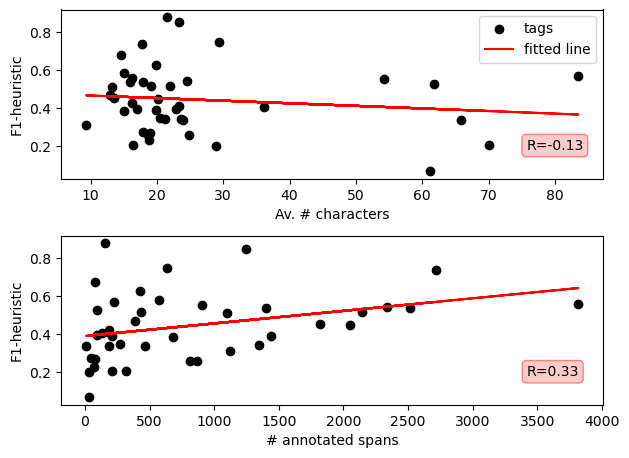

In [50]:
fig, (ax1, ax2) = plt.subplots(2)

fig.tight_layout(pad=2.0) # using padding
#fig.suptitle('Length distribution of spans') # optional

ax1.scatter(scoreframe_tag_sorted['av_no_char'], scoreframe_tag_sorted['score'], color = "black", label = "tags")
ax1.plot(scoreframe_tag_sorted['av_no_char'], char_regr.intercept 
         + char_regr.slope*scoreframe_tag_sorted['av_no_char'], 'r', label='fitted line')
ax1.set_xlabel('Av. # characters')
ax1.set_ylabel('F1-heuristic')
ax1.legend()
ax1.text(80, 0.2, "R="+str(round(char_regr.rvalue, 2)), size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

ax2.scatter(scoreframe_tag_sorted['length_spanlist'], scoreframe_tag_sorted['score'], color = "black")
ax2.plot(scoreframe_tag_sorted['length_spanlist'], ann_span_regr.intercept + ann_span_regr.slope*scoreframe_tag_sorted['length_spanlist'], 'r', label='fitted line')
ax2.set_xlabel('# annotated spans')
ax2.set_ylabel('F1-heuristic')
#ax2.legend()
ax2.text(3620, 0.2, "R="+str(round(ann_span_regr.rvalue, 2)), size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

plt.savefig('IAA_by_tag.png', dpi=300)
plt.show()